## Exploring the 1D Wave Spectra Data

Notes - 4-9-2023
Model training extended considerably, DO NOT RUN ALL
Thoughts to progress, 
* how to encode categories and energy in each category as currently period is not represented
* consider adding parameters
* consider training to obs

In [275]:
import pandas as pd
import matplotlib.pyplot as plt

## Get the 1d Spectra
First lets get and compare the 1D spectra

In [276]:
offshore = pd.read_csv('./data/spec1D_offshore.csv', parse_dates= True, index_col = 0)

In [277]:
offshore.head(1)

,0.035,0.0385,0.04235,0.046585,0.051244,0.056368,0.062005,0.068205,0.075026,0.082528,...,0.214057,0.235463,0.259009,0.28491,0.313401,0.344741,0.379215,0.417136,0.45885,0.504735
2010-01-01,0.0,0.0,0.0,0.0,0.000305,0.002664,0.008489,0.015421,0.032206,0.092174,...,0.404897,0.292953,0.212173,0.151371,0.10721,0.075437,0.052506,0.0354,0.023589,0.015501


In [278]:
gc = pd.read_csv('./data/spec1D_GC.csv', parse_dates = True, index_col = 0)

<Axes: >

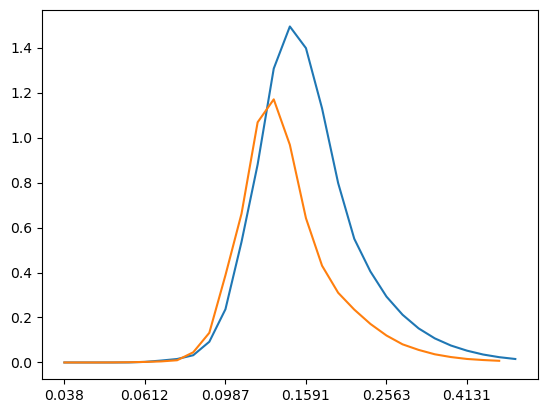

In [279]:
offshore.iloc[0].plot()
gc.iloc[0].plot()

## Get wave parameters
Get the wave parameters for the offshore an nearshore conditions

In [280]:
offStat = pd.read_csv('./data/stats_offshore.csv', parse_dates = True, index_col=0)
gcStat = pd.read_csv('./data/stats_GC.csv', parse_dates = True, index_col = 0)

<Axes: xlabel='time'>

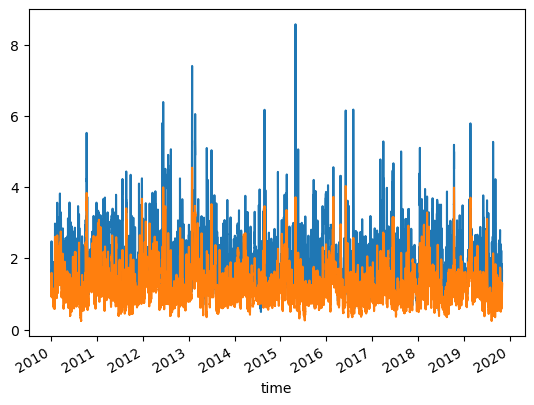

In [281]:
offStat.hs.plot()
gcStat.hs.plot()

<Axes: xlabel='time'>

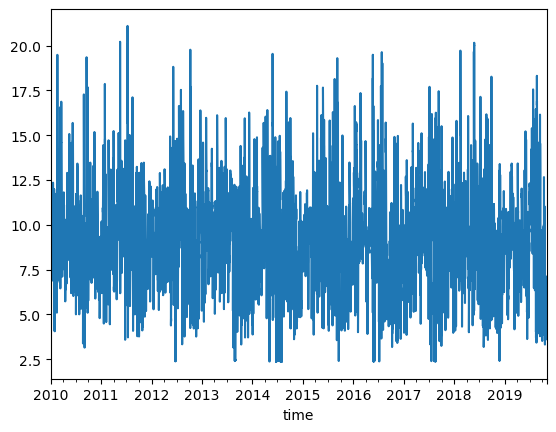

In [282]:
gcStat.tp.plot()

In [283]:
offStat.columns

Index(['lat', 'lon', 'hs', 'hmax', 'tp', 'tm01', 'tm02', 'dpm', 'dm', 'dspr',
       'swe'],
      dtype='object')

## Prepare for ML Training

In [284]:
offData = pd.merge(offshore, offStat[['hs','swe']], left_index = True, right_index = True)
data = pd.merge(gcStat['hs'], offData, right_index = True, left_index = True)

In [285]:
data = data.dropna()
data = data.sort_index()

<Axes: >

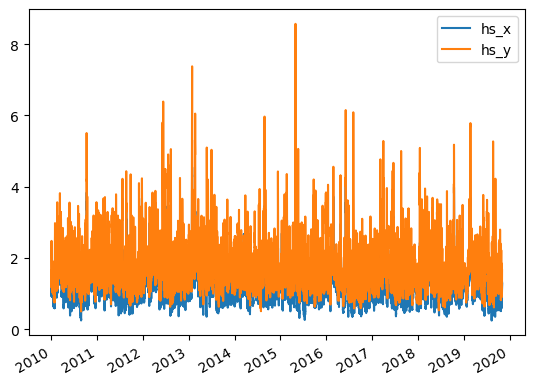

In [286]:
data[['hs_x','hs_y']].plot()

In [287]:
ind = data.loc['2019-01-01':]
data = data.loc['2016-01-01':'2019-01-01']

In [288]:
labelsName = 'hs_x'

In [289]:
features = data[data[data.loc[:, data.columns != labelsName].columns[0:-2]].columns]
labels = data[labelsName]

Scaling

In [290]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [291]:
from sklearn.model_selection import TimeSeriesSplit

In [292]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, shuffle = False)

In [293]:
norm_f = MinMaxScaler().fit(features)
X_train = norm_f.transform(features)
norm_l = MinMaxScaler().fit(labels.values.reshape(-1, 1))
y_train = norm_l.transform(labels.values.reshape(-1, 1))

## Training

In [294]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import pickle

In [295]:
clf_mlp1 = MLPRegressor(hidden_layer_sizes = (10,10,10),
                                             activation = 'relu',
                                             solver = 'adam',
                                             shuffle = False,
                                             early_stopping = True,
                                             random_state = 0)

In [296]:
param_grid = {
    'hidden_layer_sizes': [(25, 25, 25), (10,10,10),(6,6,6,6,6)],
    'activation': ['relu'],
    'alpha': [0.0001],
    'learning_rate_init': [ 0.01],
    'batch_size': [64],
}

In [299]:
len(data)//(3*24)

243

In [300]:
#grid_search = GridSearchCV(clf_mlp1, param_grid,n_jobs=-1, scoring='neg_mean_squared_error')
tscv = TimeSeriesSplit(n_splits=250)  # Use time series cross-validation
grid_search = GridSearchCV(estimator=clf_mlp1, param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)

In [301]:
grid_search.fit(X_train, y_train.ravel())

Fitting 250 folds for each of 3 candidates, totalling 750 fits
[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(25, 25, 25), learning_rate_init=0.01; total time=   0.1s
[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(25, 25, 25), learning_rate_init=0.01; total time=   0.2s
[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(25, 25, 25), learning_rate_init=0.01; total time=   0.1s
[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(25, 25, 25), learning_rate_init=0.01; total time=   0.1s
[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(25, 25, 25), learning_rate_init=0.01; total time=   0.2s
[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(25, 25, 25), learning_rate_init=0.01; total time=   0.2s
[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(25, 25, 25), learning_rate_init=0.01; total time=   0.3s
[CV] END acti

/Users/lpeach/miniconda3/envs/mlenv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(10, 10, 10), learning_rate_init=0.01; total time=   0.3s


/Users/lpeach/miniconda3/envs/mlenv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(10, 10, 10), learning_rate_init=0.01; total time=   0.3s
[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(25, 25, 25), learning_rate_init=0.01; total time=   3.8s
[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(10, 10, 10), learning_rate_init=0.01; total time=   0.1s


/Users/lpeach/miniconda3/envs/mlenv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/lpeach/miniconda3/envs/mlenv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(10, 10, 10), learning_rate_init=0.01; total time=   0.4s
[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(10, 10, 10), learning_rate_init=0.01; total time=   0.4s
[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(10, 10, 10), learning_rate_init=0.01; total time=   0.1s
[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(25, 25, 25), learning_rate_init=0.01; total time=   2.3s
[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(10, 10, 10), learning_rate_init=0.01; total time=   0.4s
[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(10, 10, 10), learning_rate_init=0.01; total time=   0.1s
[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(10, 10, 10), learning_rate_init=0.01; total time=   0.5s


/Users/lpeach/miniconda3/envs/mlenv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(10, 10, 10), learning_rate_init=0.01; total time=   0.3s
[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(10, 10, 10), learning_rate_init=0.01; total time=   0.5s
[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(10, 10, 10), learning_rate_init=0.01; total time=   0.3s
[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(25, 25, 25), learning_rate_init=0.01; total time=   3.8s
[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(10, 10, 10), learning_rate_init=0.01; total time=   0.4s
[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(10, 10, 10), learning_rate_init=0.01; total time=   0.4s
[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(25, 25, 25), learning_rate_init=0.01; total time=   5.4s
[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(1

/Users/lpeach/miniconda3/envs/mlenv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(10, 10, 10), learning_rate_init=0.01; total time=   0.7s
[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(10, 10, 10), learning_rate_init=0.01; total time=   0.1s
[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(10, 10, 10), learning_rate_init=0.01; total time=   0.2s
[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(10, 10, 10), learning_rate_init=0.01; total time=   0.2s
[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(10, 10, 10), learning_rate_init=0.01; total time=   0.7s
[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(10, 10, 10), learning_rate_init=0.01; total time=   0.2s
[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(10, 10, 10), learning_rate_init=0.01; total time=   0.2s
[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(2

/Users/lpeach/miniconda3/envs/mlenv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(10, 10, 10), learning_rate_init=0.01; total time=   3.7s
[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(10, 10, 10), learning_rate_init=0.01; total time=   1.4s
[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(10, 10, 10), learning_rate_init=0.01; total time=   1.8s
[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(10, 10, 10), learning_rate_init=0.01; total time=   1.2s
[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(10, 10, 10), learning_rate_init=0.01; total time=   1.6s
[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(10, 10, 10), learning_rate_init=0.01; total time=   1.8s
[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(10, 10, 10), learning_rate_init=0.01; total time=   0.9s
[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(1

/Users/lpeach/miniconda3/envs/mlenv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/lpeach/miniconda3/envs/mlenv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(6, 6, 6, 6, 6), learning_rate_init=0.01; total time=   0.7s
[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(6, 6, 6, 6, 6), learning_rate_init=0.01; total time=   0.8s
[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(6, 6, 6, 6, 6), learning_rate_init=0.01; total time=   0.3s
[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(6, 6, 6, 6, 6), learning_rate_init=0.01; total time=   0.4s
[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(6, 6, 6, 6, 6), learning_rate_init=0.01; total time=   0.8s


/Users/lpeach/miniconda3/envs/mlenv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(6, 6, 6, 6, 6), learning_rate_init=0.01; total time=   0.1s
[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(6, 6, 6, 6, 6), learning_rate_init=0.01; total time=   0.3s
[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(6, 6, 6, 6, 6), learning_rate_init=0.01; total time=   0.2s
[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(10, 10, 10), learning_rate_init=0.01; total time=   5.5s
[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(10, 10, 10), learning_rate_init=0.01; total time=   3.8s
[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(6, 6, 6, 6, 6), learning_rate_init=0.01; total time=   0.7s
[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden_layer_sizes=(6, 6, 6, 6, 6), learning_rate_init=0.01; total time=   0.7s
[CV] END activation=relu, alpha=0.0001, batch_size=64, hidden

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=250, test_size=None),
             estimator=MLPRegressor(early_stopping=True,
                                    hidden_layer_sizes=(10, 10, 10),
                                    random_state=0, shuffle=False),
             n_jobs=-1,
             param_grid={'activation': ['relu'], 'alpha': [0.0001],
                         'batch_size': [64],
                         'hidden_layer_sizes': [(25, 25, 25), (10, 10, 10),
                                                (6, 6, 6, 6, 6)],
                         'learning_rate_init': [0.01]},
             scoring='neg_mean_squared_error', verbose=2)

In [302]:
grid_search.best_params_

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 64,
 'hidden_layer_sizes': (6, 6, 6, 6, 6),
 'learning_rate_init': 0.01}

In [303]:
best_nn_model = grid_search.best_estimator_

In [304]:
import xgboost

In [311]:
from xgboost import XGBRegressor
from xgboost import plot_importance, plot_tree
import xgboost as xgb

In [312]:
X = pd.DataFrame(X_train)
X.columns = data[data.loc[:, data.columns != labelsName].columns[0:-2]].columns

In [313]:
xg_model = XGBRegressor(objective='reg:squarederror', random_state=42)

In [314]:
xg_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [315]:
param_grid = {
    'n_estimators': [500, 300],
    'learning_rate': [0.1],
}
tscv = TimeSeriesSplit(n_splits=10)
# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=xg_model, param_grid=param_grid, n_jobs=-1, cv = tscv, verbose=2, scoring='neg_mean_squared_error')

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score (Negative Mean Squared Error): ", grid_search.best_score_)


Fitting 10 folds for each of 2 candidates, totalling 20 fits
[CV] END ................learning_rate=0.1, n_estimators=500; total time=   2.1s
[CV] END ................learning_rate=0.1, n_estimators=500; total time=   6.2s
[CV] END ................learning_rate=0.1, n_estimators=500; total time=   9.6s
[CV] END ................learning_rate=0.1, n_estimators=300; total time=   1.9s
[CV] END ................learning_rate=0.1, n_estimators=500; total time=  12.4s
[CV] END ................learning_rate=0.1, n_estimators=500; total time=  15.3s
[CV] END ................learning_rate=0.1, n_estimators=300; total time=   4.0s
[CV] END ................learning_rate=0.1, n_estimators=300; total time=   5.7s
[CV] END ................learning_rate=0.1, n_estimators=500; total time=  18.2s
[CV] END ................learning_rate=0.1, n_estimators=500; total time=  22.0s
[CV] END ................learning_rate=0.1, n_estimators=300; total time=   7.4s
[CV] END ................learning_rate=0.1, n_es

In [316]:
best_xgb_model = grid_search.best_estimator_

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

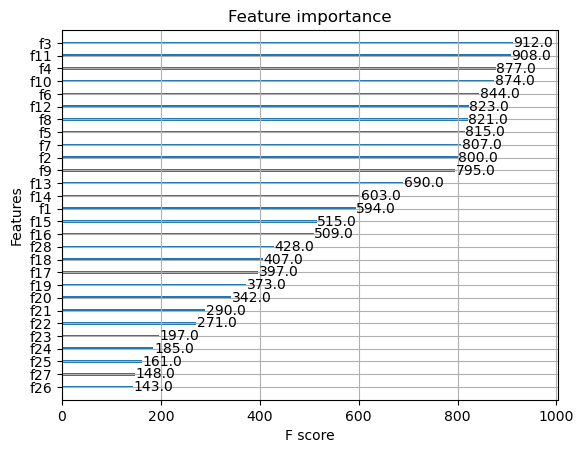

In [317]:
xgb.plot_importance(best_xgb_model)

# Prediction

In [318]:
preds = norm_l.inverse_transform(best_nn_model.predict(norm_f.transform(ind[ind[ind.loc[:, data.columns != labelsName].columns[0:-2]].columns])).reshape(-1,1))
preds_xbg = norm_l.inverse_transform(best_xgb_model.predict(norm_f.transform(ind[ind[ind.loc[:, data.columns != labelsName].columns[0:-2]].columns])).reshape(-1,1))

In [319]:
preds = pd.DataFrame(preds)
preds.index = ind.index
preds.columns = ['hs_ml']

preds_xbg = pd.DataFrame(preds_xbg)
preds_xbg.index = ind.index
preds_xbg.columns = ['hs_ml']

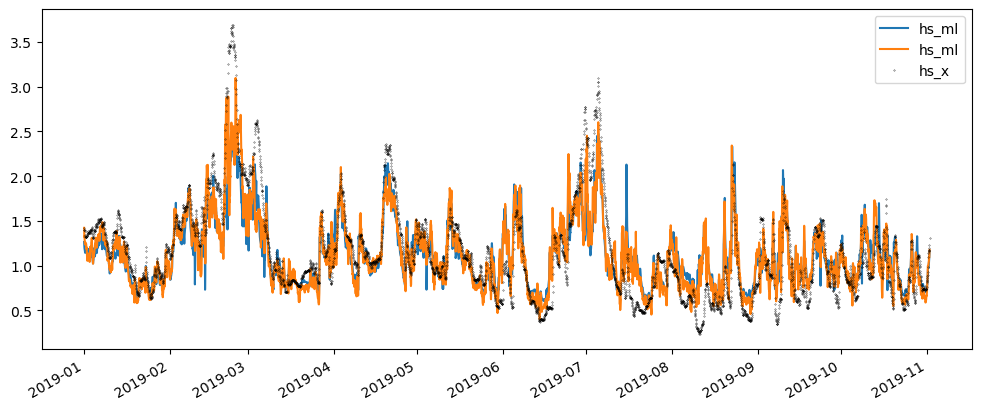

In [320]:
ax = preds.plot(markersize = 1.5, figsize = (12,5))
preds_xbg.plot(ax = ax, markersize = 1.)
ind.hs_x.plot(style = '.',ax = ax, color = 'black', markersize = 0.5)
#gcStat.loc[ind.index[0]:ind.index[-1]].swe.plot(style = '.', markersize = 0.5,ax = ax, color = 'black')
plt.legend()

In [ ]:
import matplotlib.pyplot as plt


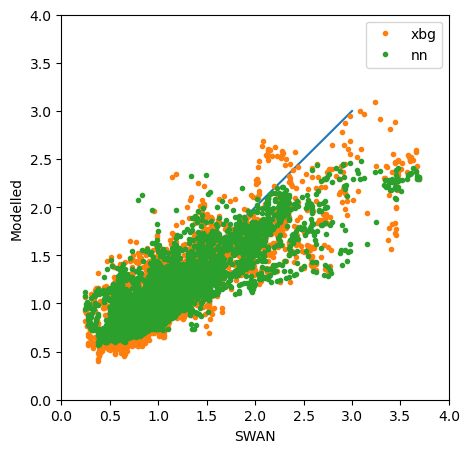

In [ ]:
plt.figure(figsize = (5,5))
plt.plot((.5,3),(.5,3))
plt.plot(ind.hs_x, preds_xbg, '.', label = 'xbg')
plt.plot(ind.hs_x, preds, '.', label = 'nn')
plt.xlim(0., 4)
plt.ylim(0., 4)
plt.ylabel('Modelled')
plt.xlabel('SWAN')
plt.legend()

In [94]:
import cal_stats

In [95]:
stat = pd.DataFrame([cal_stats.all_stats(preds['hs_ml'].values, ind.swe_x.values),
              cal_stats.all_stats(preds_xbg['hs_ml'].values, ind.swe_x.values)],
              index = ['NN','XBG']).T.reindex()
stat = stat.reset_index()

In [96]:
import plotly.graph_objects as go

In [97]:
table = go.Table(
    header=dict(values=list(stat.columns)),
    cells=dict(values=stat.transpose().values.tolist())
)

In [99]:
# Define the traces for actual, predicted, and other values
obs_trace = go.Scatter(x=ind.index, y= ind.hs.values, name='SWAN', line=dict(color='purple'))
#actual_trace = go.Scatter(x=ind.index, y=ind.loc[startDate:]['Obs'], name='Actual', mode='markers', marker=dict(color='black', size=4))
nn_predicted_trace = go.Scatter(x=preds.index, y=preds['hs_ml'].values, name='NN Predicted', line=dict(color='red'))
xgboost_predicted_trace = go.Scatter(x=preds_xbg.index, y=preds_xbg['hs_ml'].values, name='XGBoost Predicted', line=dict(color='orange'))

#ec_trace = go.Scatter(x=ind.loc[startDate:]['timestamp'], y = ind.loc[startDate:]['EC'], name='EC', line=dict(color='green'))

# Create the figure and add the traces
line = go.Figure(data=[obs_trace,  nn_predicted_trace, xgboost_predicted_trace])
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=2, cols=1,
    shared_xaxes=False,
    vertical_spacing=.25,
    specs=[[{"type": "scatter"}],
           [{"type": "table"}]]
)
fig.add_trace(table, row=2, col=1)
for myplts in [obs_trace, nn_predicted_trace, xgboost_predicted_trace]:
    fig.add_trace(myplts, row=1, col=1)
# Update the layout
fig.update_layout(
    title='Swell Forecast: SWAN vs Machine Learning',
    xaxis=dict(title='Time'),
    yaxis=dict(title='Hs (swell, >8seconds)'),
    legend=dict(x=0, y=1),
    showlegend=True
)

# Display the plot
fig.write_html('swellFcst.html')
fig.show()